In [13]:
import numpy as np
import os
import matplotlib.pyplot as plt

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import SimpleRNN, Dense, LSTM
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix

In [14]:
# GPU 할당
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

# 0518_1
## 1차 학습 데이터 6603
come, away, spin, stop

## 2차 학습 데이터 0518_1_1
come, away, spin, stop + 0428_1의 x1,x2,x3 덮어씌움



In [15]:
# 동작 지정
actions = ['come', 'away', 'spin', 'stop', 'x1', 'x2', 'x3']

data = np.concatenate([
    np.load('dataset/0518_1\seq_come_1716036603.npy'),
    np.load('dataset/0518_1\seq_away_1716036603.npy'),
    np.load('dataset/0518_1\seq_spin_1716036603.npy'),
    np.load('dataset/0518_1\seq_stop_1716036603.npy'),
    np.load('dataset/0428_1\seq_x1_1714276484.npy'),
    np.load('dataset/0428_1\seq_x2_1714276484.npy'),
    np.load('dataset/0428_1\seq_x3_1714276484.npy')
], axis=0)

date='0618_1'

data.shape

(19298, 50, 100)

535mb + 200mb

In [16]:
# 마지막에 포함된 라벨 값을 빼기 위해 -1을 함
x_data = data[:, :, :-1]
# 마지막 값을 라벨로 지정
labels = data[:, 0, -1]

print(x_data.shape)
print(labels.shape)

(19298, 50, 99)
(19298,)


In [17]:
# 원핫인코딩
y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

(19298, 7)

In [18]:
# 실수형으로 데이터 형식 변환
x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

# train, test 데이터 나누기
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.3, random_state=2021)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(13508, 50, 99) (13508, 7)
(5790, 50, 99) (5790, 7)


In [19]:
# 모델 학습 설정
model = Sequential([
    SimpleRNN(64, activation='relu', input_shape=x_train.shape[1:3]),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='mse', metrics=['acc'])
model.summary()

c:\Users\qrstu\anaconda3\envs\python_31010\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)        │ (None, 64)             │        10,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           119 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,223 (51.65 KB)

 Trainable params: 13,223 (51.65 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)는 검증 데이터 손실(val_loss)이 증가하면,
# 과적합 징후므로 검증 데이터 손실이 4회 증가하면 정해진 에포크가 도달하지 못하였더라도 학습을 조기 종료(Early Stopping)한다는 의미
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)

history = model.fit(
    x_train,
    y_train,
    batch_size = 128,
    validation_data=(x_val, y_val),
    epochs=50, 
    callbacks=[
        # ModelCheckpoint를 사용하여 검증 데이터의 정확도(val_acc)가 이전보다 좋아질 경우에만 모델을 저장
        ModelCheckpoint('models/{}/model.keras'.format(date), monitor='val_acc', verbose=1, save_best_only=True, mode='max'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Epoch 1/50
104/106 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.4499 - loss: 0.1165
Epoch 1: val_acc improved from -inf to 0.80743, saving model to models/0618_1/model.keras
106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - acc: 0.4539 - loss: 0.1154 - val_acc: 0.8074 - val_loss: 0.0391 - learning_rate: 0.0010
Epoch 2/50
103/106 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.8720 - loss: 0.0289
Epoch 2: val_acc improved from 0.80743 to 0.96874, saving model to models/0618_1/model.keras
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - acc: 0.8734 - loss: 0.0286 - val_acc: 0.9687 - val_loss: 0.0076 - learning_rate: 0.0010
Epoch 3/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.9766 - loss: 0.0060
Epoch 3: val_acc improved from 0.96874 to 0.98636, saving model to models/0618_1/model.keras
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - acc: 0.9766 - loss: 0.0060 - val_acc: 0.9864 - val_loss: 0.0032 - learning_rate: 0.0010
Epoch 4/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.9852 - loss: 0.0037


In [21]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)        │ (None, 64)             │        10,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           119 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,671 (154.97 KB)

 Trainable params: 13,223 (51.65 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 26,448 (103.32 KB)

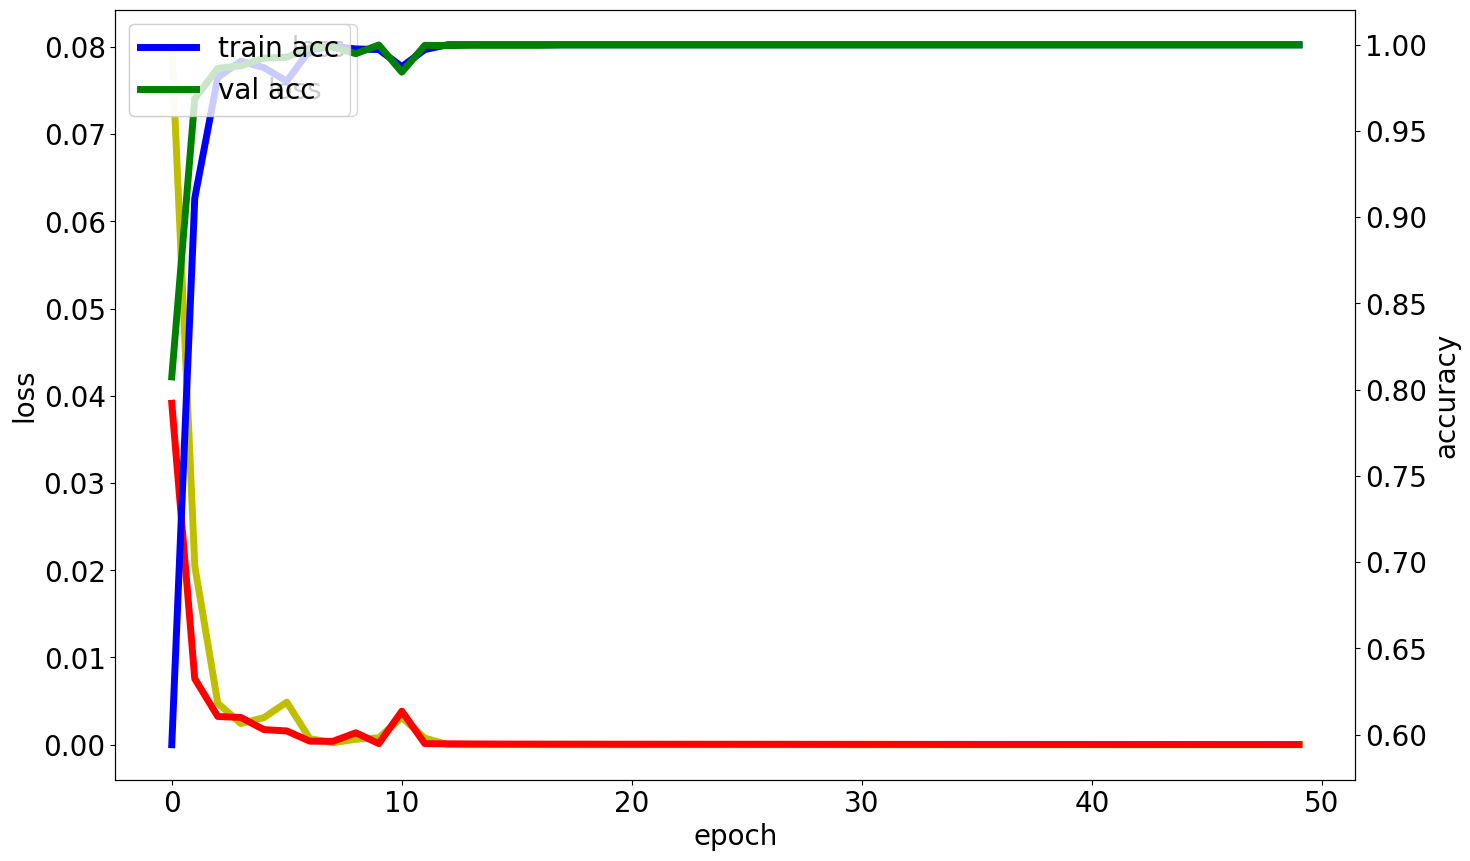

In [22]:
fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

# 손실 값 플로팅
loss_ax.plot(history.history['loss'], 'y', label='train loss', linewidth=5.0)
loss_ax.plot(history.history['val_loss'], 'r', label='val loss', linewidth=5.0)
loss_ax.set_xlabel('epoch', fontsize=20)  # x축 레이블 글자 크기 키우기
loss_ax.set_ylabel('loss', fontsize=20)   # y축 레이블 글자 크기 키우기
loss_ax.legend(loc='upper left', fontsize=20)  # 범례 글자 크기 키우기
loss_ax.tick_params(axis='x', labelsize=20)  # x축 눈금 레이블 글자 크기 키우기
loss_ax.tick_params(axis='y', labelsize=20)  # y축 눈금 레이블 글자 크기 키우기

# 정확도 플로팅
acc_ax.plot(history.history['acc'], 'b', label='train acc', linewidth=5.0)
acc_ax.plot(history.history['val_acc'], 'g', label='val acc', linewidth=5.0)
acc_ax.set_ylabel('accuracy', fontsize=20)  # y축 레이블 글자 크기 키우기
acc_ax.legend(loc='upper left', fontsize=20)  # 범례 글자 크기 키우기
acc_ax.tick_params(axis='y', labelsize=20)  # y축 눈금 레이블 글자 크기 키우기

plt.show()


In [23]:
loss, acc = model.evaluate(x_val, y_val)

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.9999 - loss: 1.4241e-05


In [24]:
model = load_model('models/{}/model.keras'.format(date))

y_pred = model.predict(x_val)

multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


array([[[4716,    0],
        [   1, 1073]],

       [[4742,    1],
        [   0, 1047]],

       [[4802,    0],
        [   0,  988]],

       [[4699,    0],
        [   0, 1091]],

       [[5244,    0],
        [   0,  546]],

       [[5261,    0],
        [   0,  529]],

       [[5275,    0],
        [   0,  515]]], dtype=int64)